<a href="https://colab.research.google.com/github/kentoabeywardane/COVID19-In-Host-Viral-Load-Modeling/blob/main/ENGN_2911R_In-Host_Viral_Load_Modeling_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from matplotlib import gridspec
from scipy.integrate import odeint, ode
import seaborn as sns
sns.set_style("darkgrid")

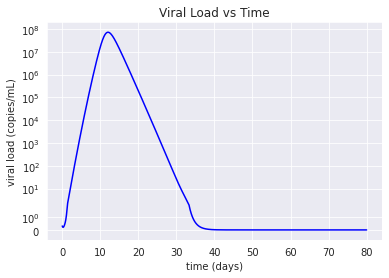

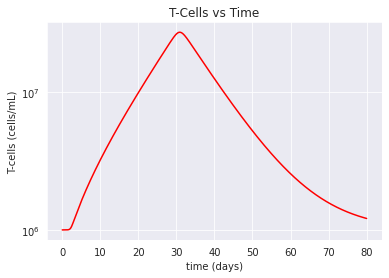

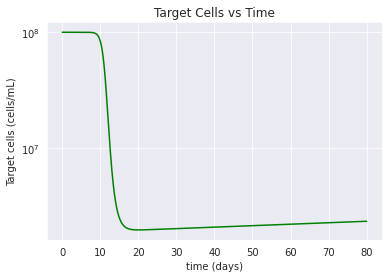

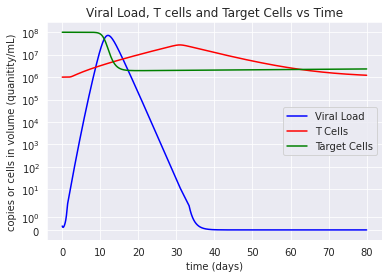

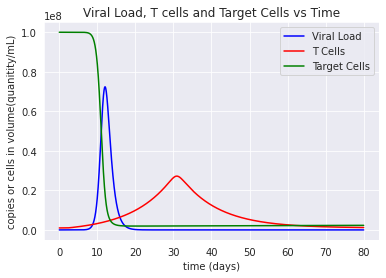

In [2]:
# Our Novel Model 
# combination of techniques from: https://elifesciences.org/articles/69302#content
## and https://www.sciencedirect.com/science/article/pii/S1367578820300638?via%3Dihub#bib0004

def dydt(y, t, params):
  """System of ODEs to produce a total in-body model of COVID-19 with immune response.\n
  y = [U, E, I, VI, VNI, T]\n
  params = [b, k, d, p, mu, c, ct, r]"""
  U, E, I, VI, VNI, T = y
  b, k, d, p, mu, c, ct, r = params
  
  dUdt =  (n*U*(1-U/U0)) - (b*U*VI) # target cells
  dEdt = (b*U*VI) - (k*E) # latent cells
  dIdt = (k*E) - (d*I) # infected cells
  dVIdt = ((p*mu*I) + (pt*VI*(1 - VI/K))) - (ct*VI*T) - (c*VI) # infectious virions
  dVNIdt = (p*(1-mu)*I) + (pt*VNI*(1 - VNI/K)) - (ct*VNI*T) - (c*VNI) # noninfectious virions
  st = deltat * T0
  dTdt = st + (r*T*((VI+VNI)**2/(((VI+VNI)**2) + (kt**2)))) - deltat*T # T-cells

  dydt = [dUdt, dEdt, dIdt, dVIdt, dVNIdt, dTdt]  # Pack the odes
  return dydt

# time scale
t_start = 0.0
t_end = 80.0 # days
N_time = 10001
times = np.linspace(t_start, t_end, N_time)

# Parameters
n = 0.003    # cell/day, lung cell turnover rate: https://link.springer.com/chapter/10.1007/978-3-642-69521-6_11
K =  2.35e9  # copies/ml, maximum viral load in sputum: https://www.nature.com/articles/s41586-020-2196-x
d = 0.84     # 1/day, loss rate of productively infected cells: https://elifesciences.org/articles/69302#content 
c = 10       # 1/day, clearance rate: https://elifesciences.org/articles/69302#content 
k = 3        # 1/day, eclipse phase to infected rate: journal.pcbi.1008785.pdf eclipse phase
mu = 1e-4    # unitless, proportion of infectious virus: journal.pcbi.1008785.pdf 
p = 2.8e5    # 1/cell-day, rate of viral production: https://elifesciences.org/articles/69302#content; pT (copies/cell/d) 
             # 2.2×10^4  or pN (copies/cell/d) 4.8×10^4 from journal.pcbi.1008785%20(1).pdf
pt = 5.36    # copies*day*cell/mL, replication rate https://www.sciencedirect.com/science/article/pii/S1367578820300638?via%3Dihub#bib0078 
             # pt just a variation for units taken from a second model as opposed to above p
b = 1.58e-8  # day*copies/ml  https://www.sciencedirect.com/science/article/pii/S1367578820300638?via%3Dihub#bib0078
deltat = 0.1 # 1/day
kt = 1.26e5  # copies/mL

# parameters characterizing severe cases (nonlethal)
ct = 1.89e-6 # https://www.sciencedirect.com/science/article/pii/S1367578820300638?via%3Dihub#bib0078
r = 0.194    # https://www.sciencedirect.com/science/article/pii/S1367578820300638?via%3Dihub#bib0078

#initial conds
U0 = 1.e8    # target cells/mL 
I0 = 1/30    # infected cells/mL
T0 = 1e6     # T cells/mL
V0 = .31     # copies/ml
Ro = b*p*U0*mu /(c*d) # just calculated as a test to see if R0 is in expected range (2-15)

# pack parameters and initial conditions for ode solver
params = [b,k,d,p,mu,c,ct,r]
y1 = [U0, 0, I0, V0, 0, T0]

# solve ode
answer = odeint(func=dydt, y0=y1, t=times, args=(params,))

#unpack
U = answer[:, 0]   # target cells vs time
E = answer[:, 1]   # latent cells vs time
I = answer[:, 2]   # infected cells vs time
VI = answer[:, 3]  # infectious virions vs time
VNI = answer[:, 4] # non-infectious virions vs time
T = answer[:, 5]   # T cells vs time 

# graphs
# viral load vs time
VLoad = plt.plot(times, VI, "-b", label="Viral Load")
plt.title('Viral Load vs Time')
plt.xlabel('time (days)')
plt.ylabel('viral load (copies/mL)')
plt.yscale('symlog')
plt.show()

# T cells vs time
Tcells = plt.plot(times, T, "-r", label="T Cells")
plt.title('T-Cells vs Time')
plt.xlabel('time (days)')
plt.ylabel('T-cells (cells/mL)')
plt.yscale('symlog')
plt.show()

# target cells vs time
UCells = plt.plot(times, U, "-g", label="Target Cells")
plt.title('Target Cells vs Time')
plt.xlabel('time (days)')
plt.ylabel('Target cells (cells/mL)')
plt.yscale('symlog')
plt.show()

# all three graphs combined - log scale
VLoad = plt.plot(times, VI, "-b", label="Viral Load")
Tcells = plt.plot(times, T, "-r", label="T Cells")
UCells = plt.plot(times, U, "-g", label="Target Cells")
plt.title('Viral Load, T cells and Target Cells vs Time')
plt.xlabel('time (days)')
plt.ylabel('copies or cells in volume (quanitity/mL)')
plt.legend()
plt.yscale('symlog')
plt.show()

# all three graphs combined - normal scale
VLoad = plt.plot(times, VI, "-b", label="Viral Load")
Tcells = plt.plot(times, T, "-r", label="T Cells")
UCells = plt.plot(times, U, "-g", label="Target Cells")
plt.title('Viral Load, T cells and Target Cells vs Time')
plt.xlabel('time (days)')
plt.ylabel('copies or cells in volume(quanitity/mL)')
plt.legend()
plt.show()

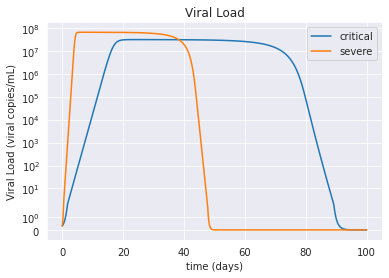

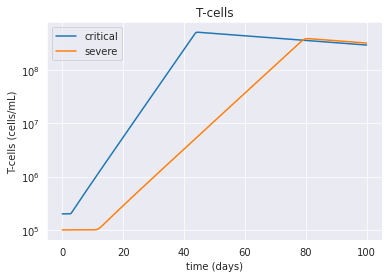

In [3]:
# Viral Load Model 1
# In-host model with T-cell response
# With reference to: https://www.sciencedirect.com/science/article/pii/S1367578820300638?via%3Dihub
## and https://www.sciencedirect.com/science/article/pii/S0169260721004867

class withimmune:
  def __init__(self, severity_params, T0):
    """severity_params = [p, ct, r]\n
    T0 = intial # of T cells """
    self.p, self.ct, self.r = severity_params
    self.T0 = T0

  def diffeqs(self, y, t):
    """Solver for COVID-19 in host model with immune response"""
    # variables
    V, T = y
    # fixed params
    K = 1e8       # copies/mL
    c = 2.4       # 1/day
    kt = 1.26e5   # copies/mL
    deltat = 0.01 # 1/day

    # ODEs
    dVdt = self.p*V*(1 - V/K) - self.ct*V*T - c*V # virions
    st = deltat * self.T0
    dTdt = st + self.r*T*(V**2/(V**2 + kt**2)) - deltat*T # T cells
    dydt = [dVdt, dTdt] # pack ODEs
    return dydt

  # runs the integrator
  def simulate(self, init_cond, tspan):
    """init_cond = [V0, T0]"""
    answer = odeint(self.diffeqs, init_cond, tspan) # solve ODEs
    V = answer[:, 0] # virions
    T = answer[:, 1] # T cells
    return V, T

# initial conditions
V0 = 0.31     # viral copies/mL
T0 = 1e6      # T cells/mL
y0 = [V0, T0]

# critical cases
p = 3.50      # 1/day
ct = 0.596e-8 # 1/day-cell
r = 0.131     # 1/day
severity_params_crit = [p,ct,r]
critical_T0 = 1e5

# severe cases
p = 6.99
ct = 1.47e-8
r = 0.2
severity_params_severe = [p,ct,r]
severe_T0 = 2e5

# time
t_start = 0.0
t_end = 100.0
N = 1000001
tspan = np.linspace(t_start, t_end, N)

# get the variables using parameters severeness=critical
critical = withimmune(severity_params_crit, critical_T0)
Vc, Tc = critical.simulate([V0, critical_T0], tspan)

# get the variables using parameters severeness=severe
severe = withimmune(severity_params_severe, severe_T0)
Vs, Ts = severe.simulate([V0, severe_T0], tspan)

plt.yscale('symlog')
plt.plot(tspan, Vc, label='critical')
plt.plot(tspan, Vs, label='severe')
plt.xlabel('time (days)')
plt.ylabel('Viral Load (viral copies/mL)')
plt.legend()
plt.title('Viral Load')
plt.show()

plt.yscale('symlog')
plt.plot(tspan, Ts, label='critical')
plt.plot(tspan, Tc, label='severe')
plt.legend()
plt.title('T-cells')
plt.ylabel('T-cells (cells/mL)')
plt.xlabel('time (days)')
plt.show()

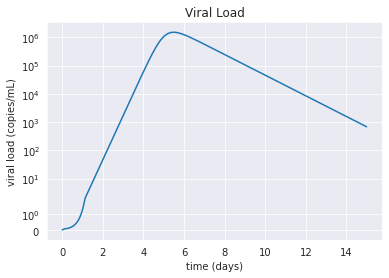

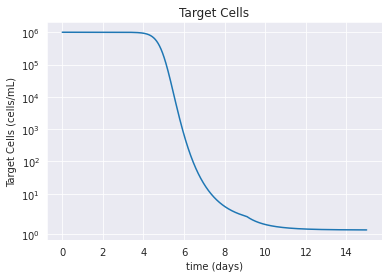

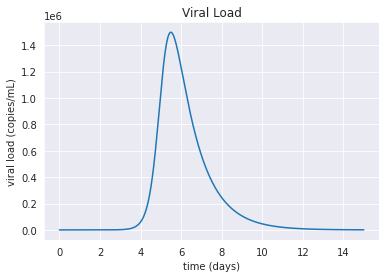

In [4]:
# Viral Load Model 2
# With Reference to: https://elifesciences.org/articles/69302#content

def dydt(y, t, params):
  """System of ODEs to get in-human model without immune response.\n
  params = [b, k, d, p, mu, c]\n
  y = [T, E, I, VI, VNI]"""
  b, k, d, p, mu, c = params
  T, E, I, VI, VNI = y
    
  dTdt = - b*T*VI # Target Cells
  dEdt = b*T*VI - k*E # Latent Cells
  dIdt = k*E - d*I # Infected Cells
  dVIdt = p*mu*I - c*VI # Infectious Virions
  dVNIdt = p*(1-mu)*I - c*VNI # Noninfectious Virions
  dydt = [dTdt, dEdt, dIdt, dVIdt, dVNIdt]  # Pack the answer.
  return dydt

# time scale
t_start = 0.0
t_end = 15.0
N_time = 10001
times = np.linspace(t_start, t_end, N_time)

# logit-linear (M2) parameters
d = 0.84    # 1/day
c = 10      # 1/day
k = 4       # 1/day
mu = 1e-4
p = 2.8e5   # 1/cell/day
R0 = 13.6
U0 = 1.33e5 # target cells/mL
I0 = 1/30   # infected cells/mL
T0 = 1e6 
b = R0*c*d/p/T0/mu

params = [b,k,d,p,mu,c] # pack parameters
y0 = [T0, 0, I0, 0, 0]  # intial conditions

# get the solution to the system of ODEs
answer = odeint(func=dydt, y0=y0, t=times, args=(params,))
T = answer[:, 0]    # Target Cells 
E = answer[:, 1]    # Latent Cells
I = answer[:, 2]    # Infected Cells
VI = answer[:, 3]   # Infectious Virions
VNI = answer[:, 4]  # Non-infectious Virions

# plot Viral Load vs time (log scale)
plt.plot(times, VI)
plt.yscale('symlog')
plt.title('Viral Load')
plt.xlabel('time (days)')
plt.ylabel('viral load (copies/mL)')
plt.show()

# plot Target Cells vs time (log scale)
plt.plot(times, T)
plt.yscale('symlog')
plt.title('Target Cells')
plt.xlabel('time (days)')
plt.ylabel('Target Cells (cells/mL)')
plt.show()

# plot Viral Load vs time
plt.plot(times, VI)
plt.title('Viral Load')
plt.xlabel('time (days)')
plt.ylabel('viral load (copies/mL)')
plt.show()